# Configuração do Ambiente

In [5]:
!pip install ucimlrepo
!pip install xgboost

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from ucimlrepo import fetch_ucirepo
import scipy.stats as stats





# Preparação dos Dados

In [7]:
abalone = fetch_ucirepo(id=1)

data = abalone.data.features.copy()
data['Rings'] = abalone.data.targets.copy()

# X = abalone.data.features.copy()
# y = abalone.data.targets.copy()

data.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


Descrição das Variáveis

`Sex`: macho, fêmea ou imaturo (categórica)

`Diameter`: maior medida do abalone (contínua)

`Length`: medida perpendicular a `Diameter` (contínua)

`Height`: altura incluido a carne e o concha (contínua)

`Whole_weight`: massa total (contínua)

`Shucked_weight`: massa da carne do molusco (contínua)

`Viscera_weight`: massa visceral do animal (contínua)

`Shell_weight`: massa da concha (contínua)

`Rings`: número de anéis na concha, utilizado para estimar a idade da criatura (inteira, variável resposta)

In [ ]:
# verificando valores nulos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole_weight    4177 non-null   float64
 5   Shucked_weight  4177 non-null   float64
 6   Viscera_weight  4177 non-null   float64
 7   Shell_weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [ ]:
data['Sex'].value_counts()

,count
Sex,
M,1528
I,1342
F,1307


In [ ]:
numericas = data.select_dtypes(include=[np.number])
data[numericas <= 0].count()

,0
Sex,0
Length,0
Diameter,0
Height,2
Whole_weight,0
Shucked_weight,0
Viscera_weight,0
Shell_weight,0
Rings,0


Substituindo os valores inválidos pelo menor valor válido:

In [ ]:
hmin = data.loc[data['Height'] > 0, 'Height'].min()
data.loc[data['Height'] == 0, 'Height'] = hmin
print(f'Menor altura válida: {hmin}')

Menor altura válida: 0.01


In [ ]:
data.describe()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139521,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041812,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.010000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


# Visualização dos dados

In [9]:

def pair_plot(dados: pd.DataFrame, hue: str):
    g = sns.PairGrid(dados, hue=hue, diag_sharey=False)

    # Parte superior: densidade conjunta
    g.map_upper(sns.kdeplot, fill=True)

    # Parte inferior: dispersão
    g.map_lower(sns.scatterplot, alpha=0.7)

    # Diagonal: histogramas com KDE
    g.map_diag(sns.histplot, kde=True, edgecolor='k')

    g.add_legend()
    plt.show()


def plot_dist(dados: pd.DataFrame, col: str, hue: str):
    plt.figure(figsize=(12, 9))

    # Histograma por grupo
    plt.subplot(2, 2, 1)
    sns.histplot(data=dados, x=col, hue=hue, kde=True, edgecolor='k')
    plt.title('Histograma por categoria')
    plt.xlabel(col)
    plt.ylabel('Frequência')

    # Histograma geral
    plt.subplot(2, 2, 2)
    sns.histplot(data=dados, x=col, kde=True, color='#8f32a8', edgecolor='k')
    plt.title('Histograma geral')
    plt.xlabel(col)
    plt.ylabel('Frequência')

    # Boxplot por grupo
    plt.subplot(2, 2, 3)
    sns.boxplot(data=dados, y=col, x=hue)
    plt.title('Boxplot por categoria')
    plt.xlabel(hue)
    plt.ylabel(col)

    # Boxplot geral
    plt.subplot(2, 2, 4)
    sns.boxplot(data=dados, y=col, width=0.3, color='#8f32a8')
    plt.title('Boxplot geral')
    plt.ylabel(col)

    plt.suptitle(f"Distribuição da variável '{col}'", fontsize=15)
    plt.tight_layout()
    plt.show()



def plot_bar(dados: pd.DataFrame, var: str, figsize: tuple, title: str):
    largura, altura = figsize
    aspect = largura / altura

    sns.catplot(
        data=dados,
        x=var,
        hue=var,
        kind='count',
        height=altura,
        aspect=aspect
    )

    plt.title(title)
    plt.show()


---

Iniciando a análise pelo pairplot, utilizamos uma visualização gráfica que apresenta, simultaneamente, as relações entre diversas variáveis do conjunto de dados. Essa ferramenta organiza uma grade de gráficos em que as diagonais exibem as distribuições individuais de cada variável enquanto os painéis fora da diagonal mostram diagramas de dispersão que evidenciam a relação entre cada par de variáveis. Com isso, torna-se possível identificar, de forma intuitiva, padrões como correlações, agrupamentos, tendências e até possíveis outliers. Por sua capacidade de revelar rapidamente a estrutura geral dos dados, o pairplot se destaca como um recurso essencial na etapa de análise exploratória, guiando interpretações e decisões futuras no processo de modelagem.


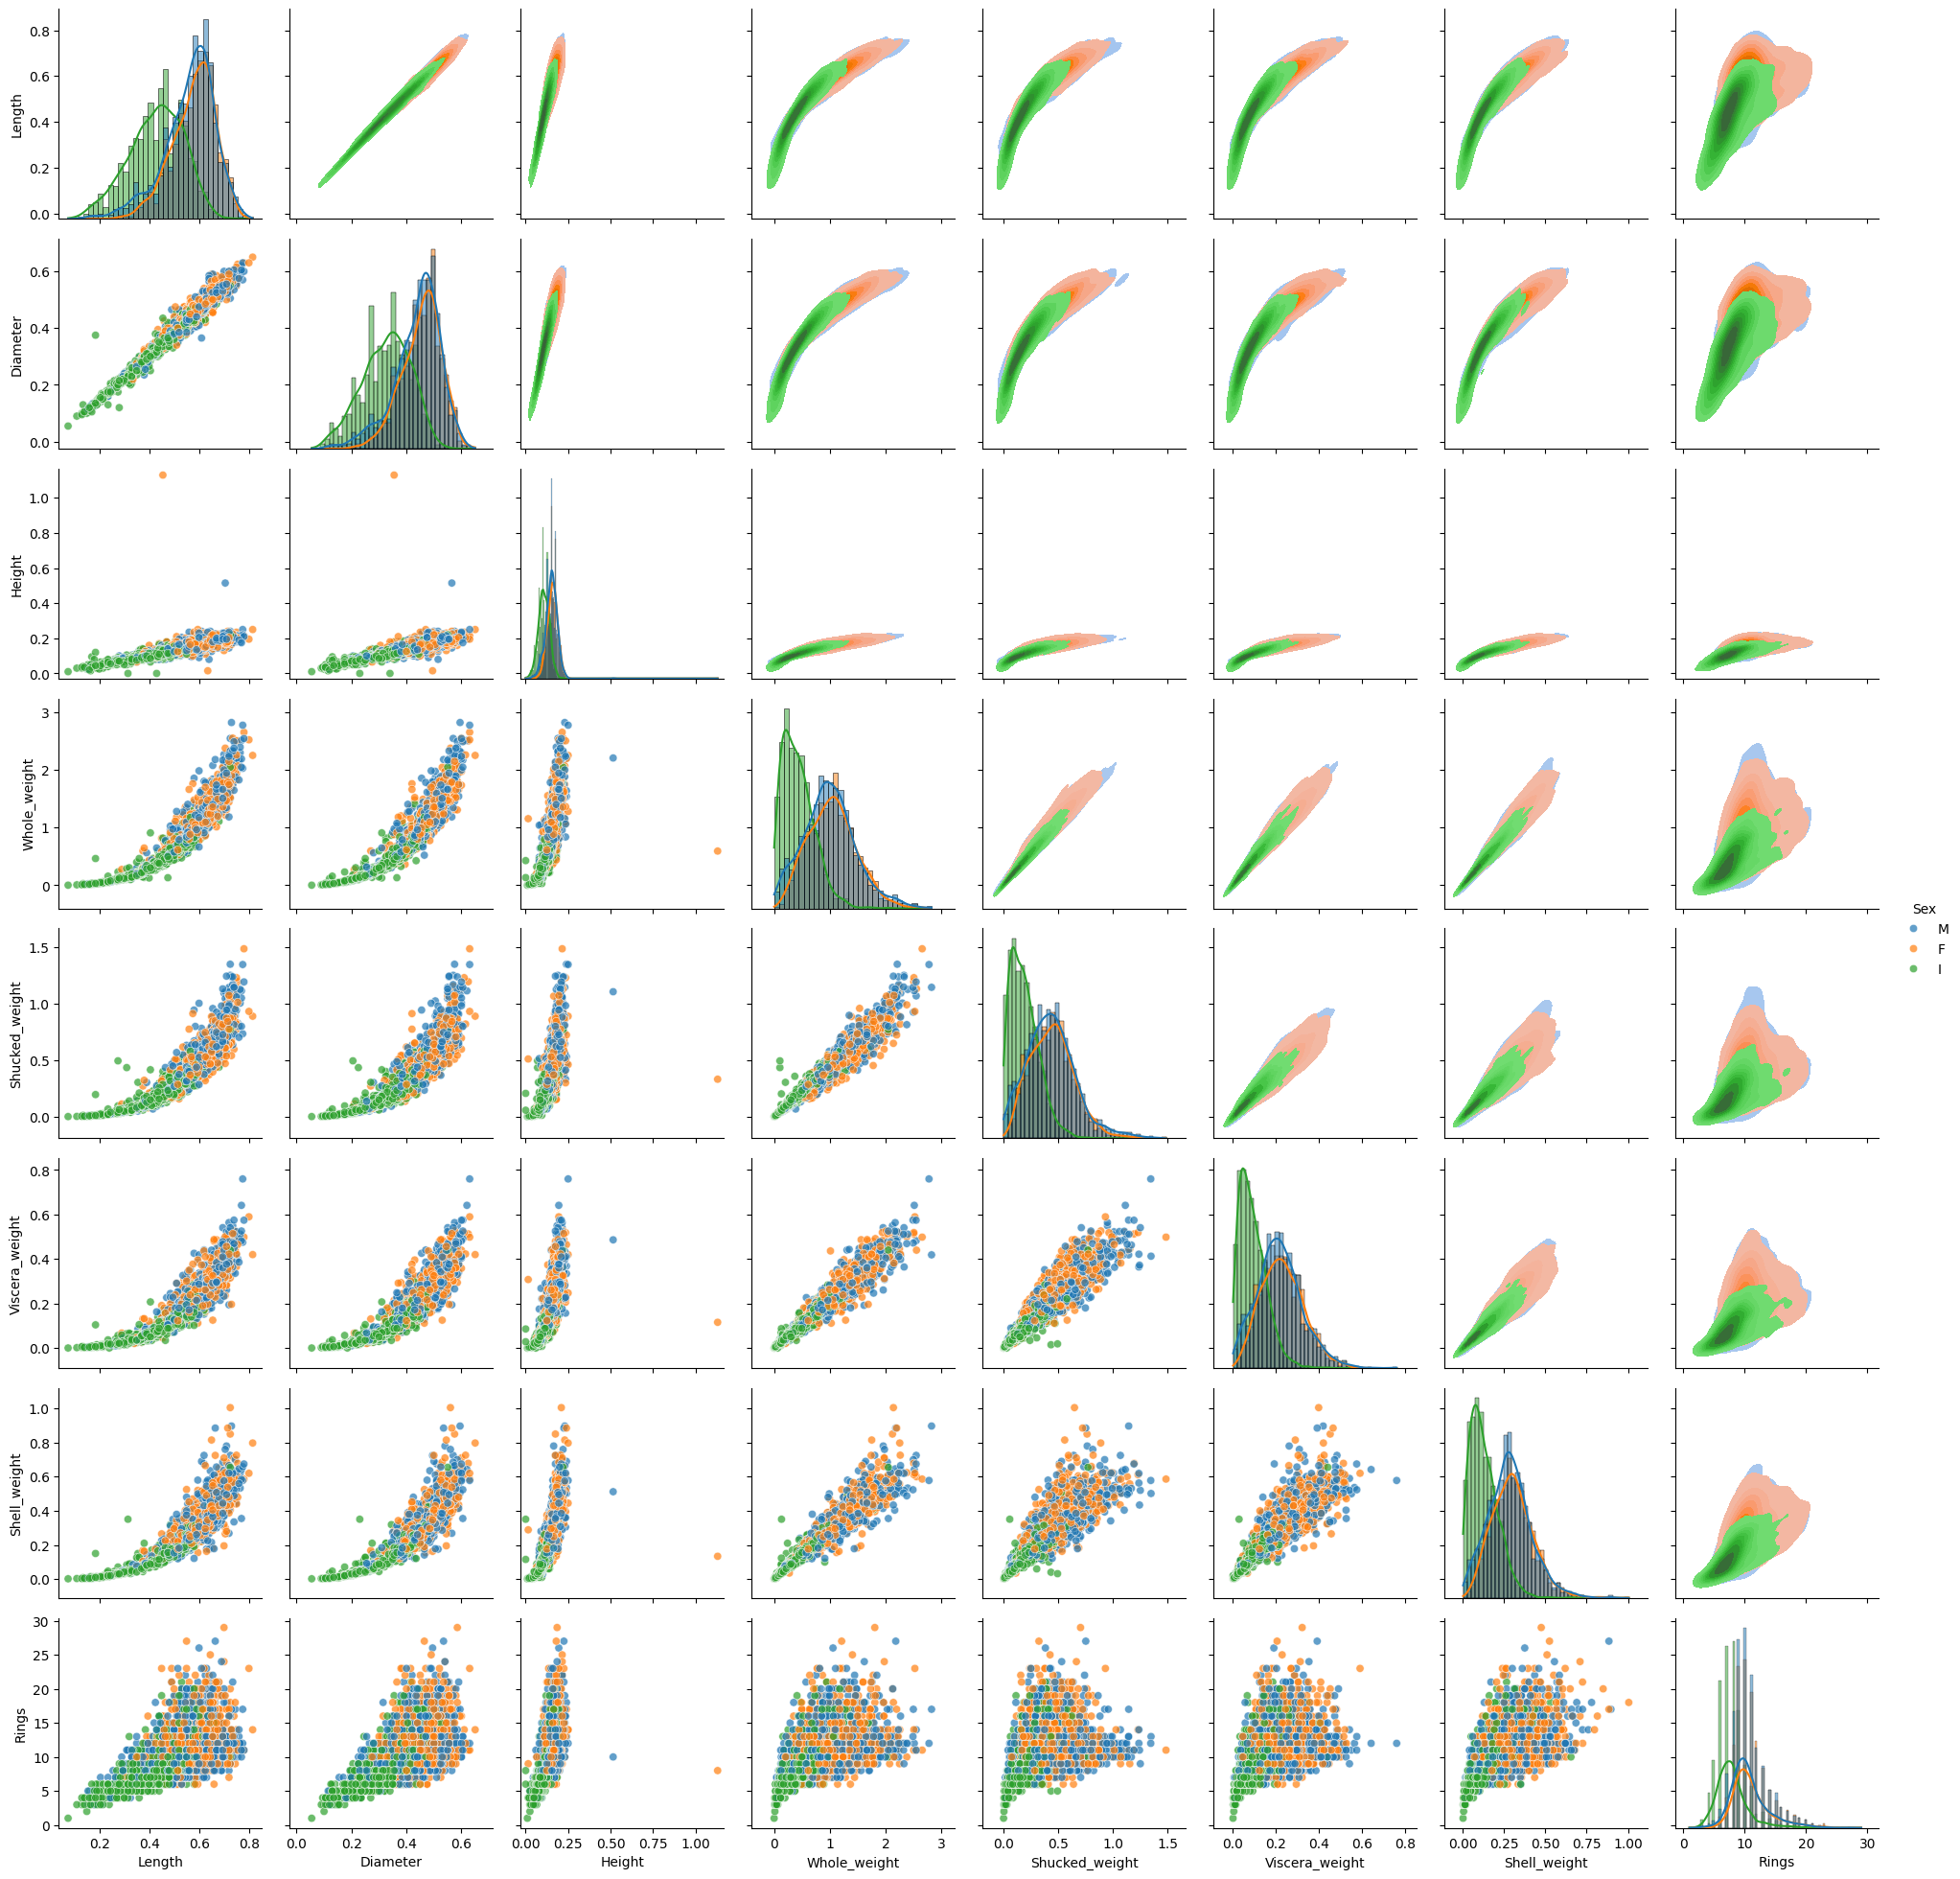

In [10]:
# Desenhando Pair Plot
pair_plot(dados = data, hue = 'Sex')

Retirando os outliers na variáveis Height, temos uma análise mais fidedigna

In [11]:
out_height = data['Height'].nlargest(2).index
data = data.drop(out_height)

Refazendo o pairplot:

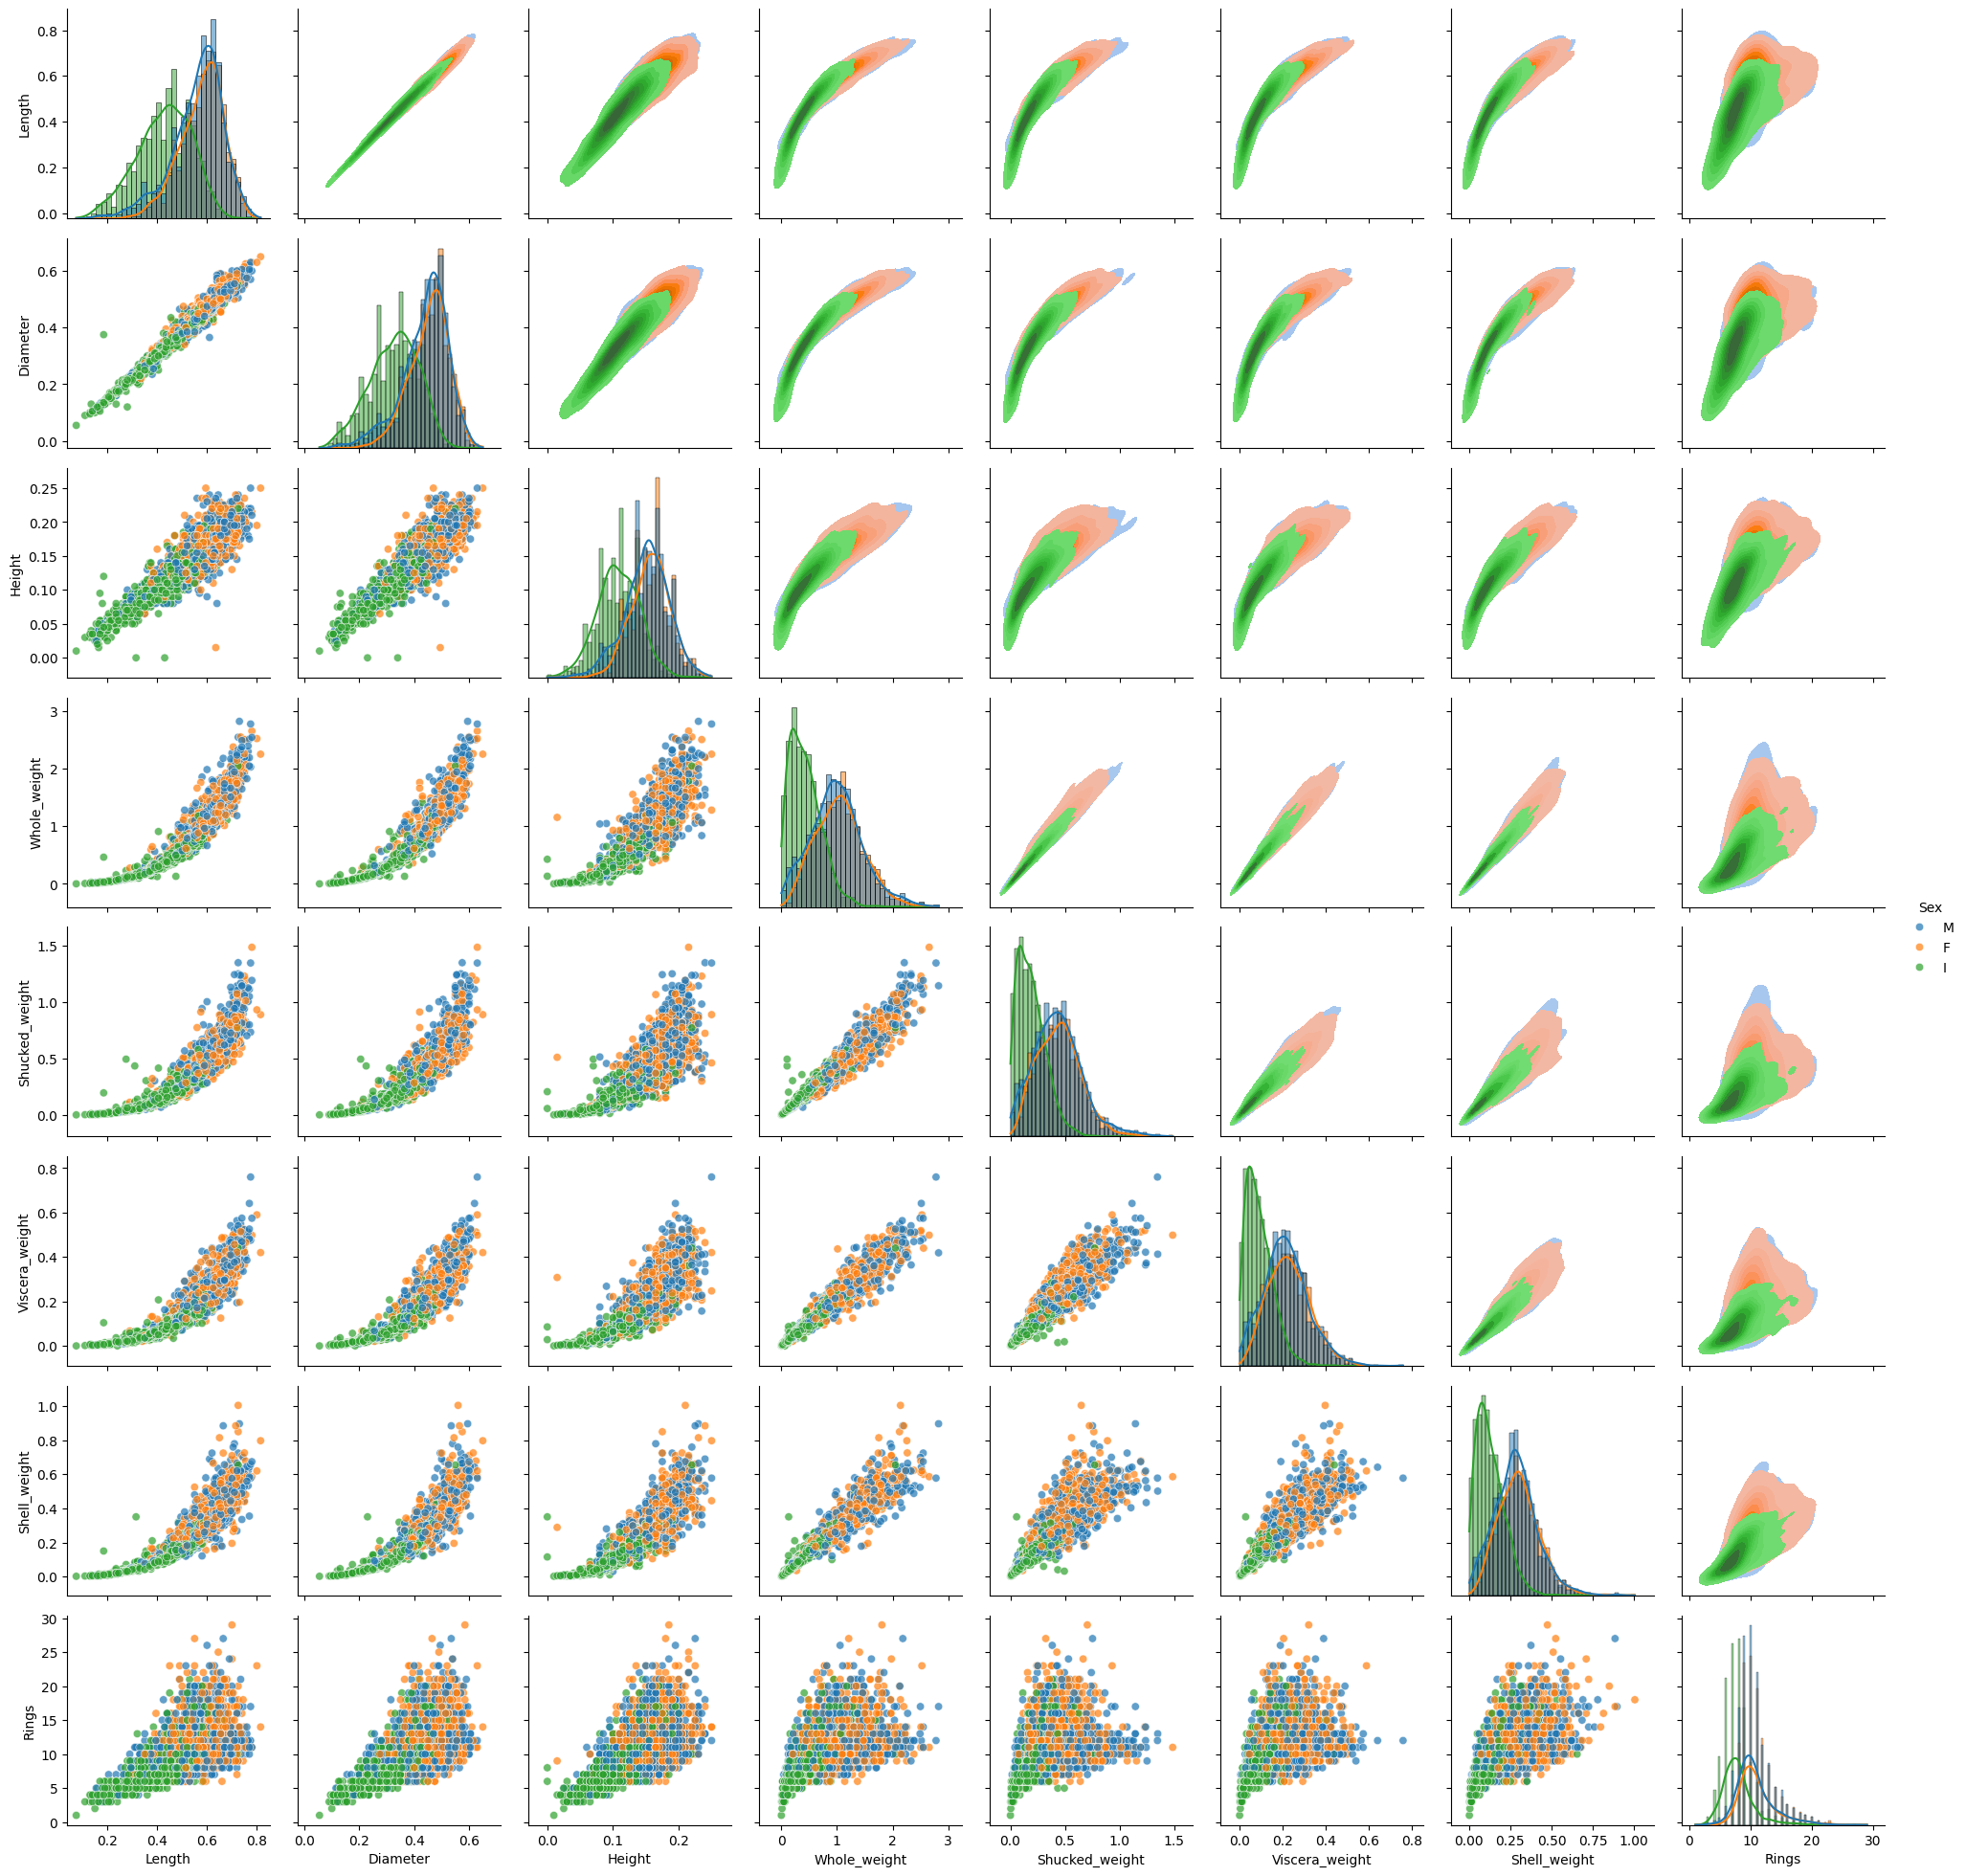

In [12]:
# Redesenhando os gráficos
pair_plot(dados = data, hue = 'Sex')

Podemos destacar alguns aspectos importantes a partir das visualizações:

* As variáveis relacionadas ao tamanho apresentam comportamentos muito semelhantes entre si e exibem correlações elevadas; o mesmo padrão se repete para as variáveis associadas à massa.
* Observa-se ainda que medidas de comprimento e de peso tendem a variar juntas, embora essa relação não siga uma forma estritamente linear.
* A variável alvo Rings mostra um aumento geral conforme as demais variáveis crescem, porém com grande dispersão. Essa alta variabilidade sugere que a capacidade das features explicarem Rings é limitada, o que pode dificultar o desempenho de modelos preditivos.


Visualizando agora a distribuição de cada váriavel:

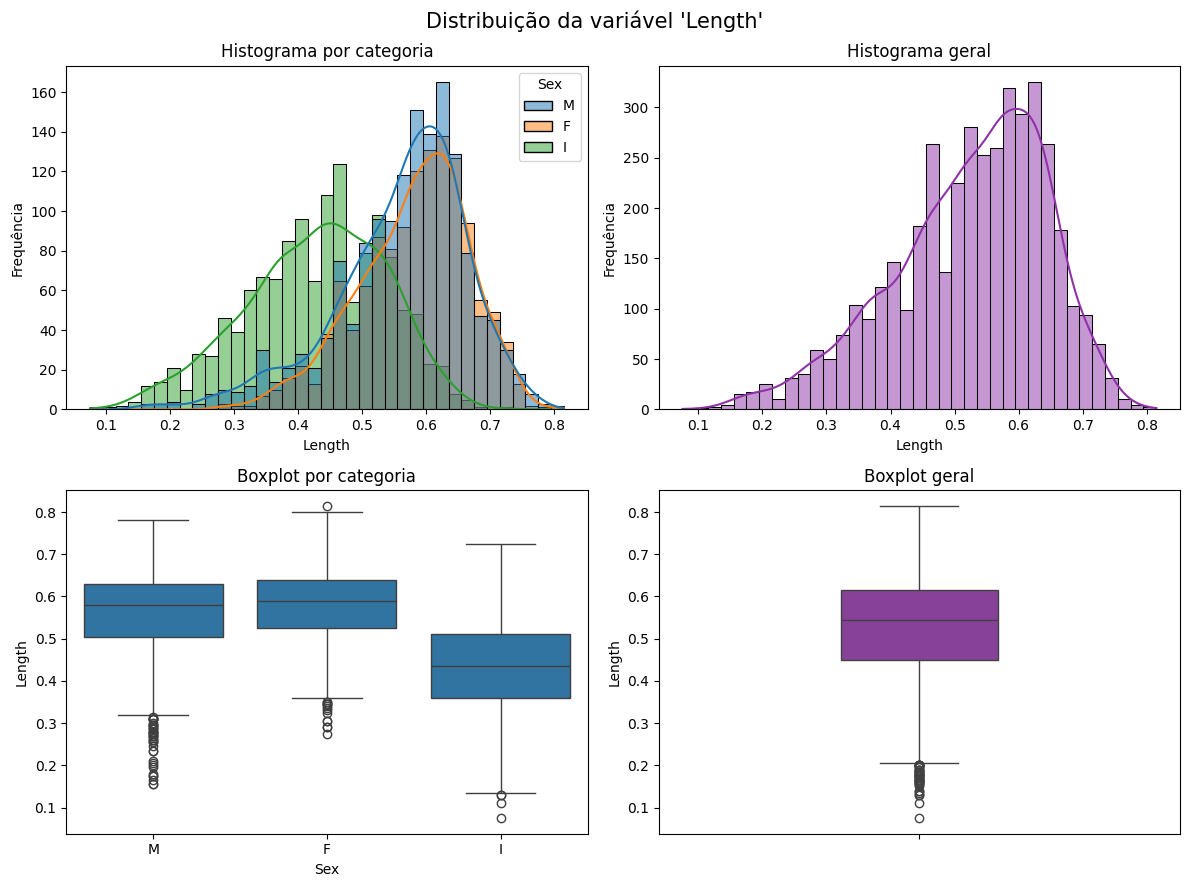

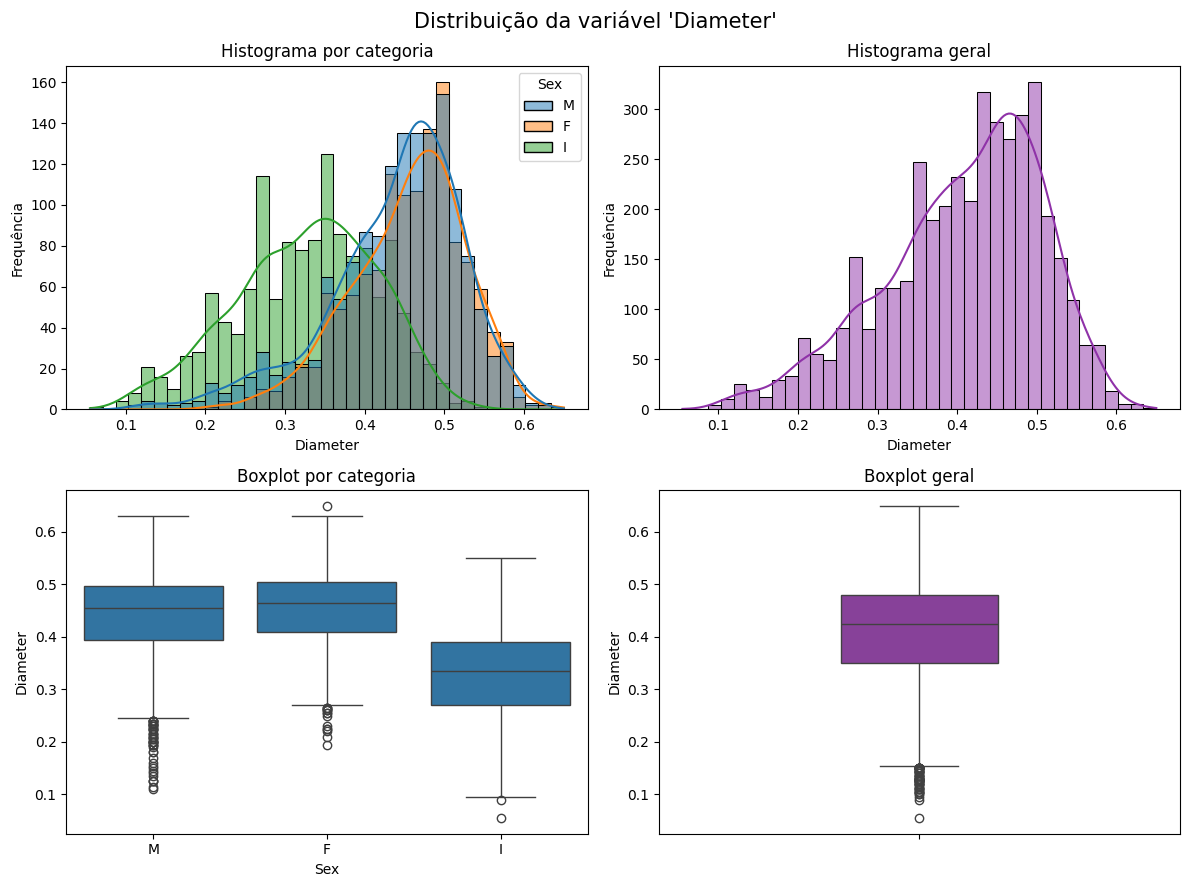

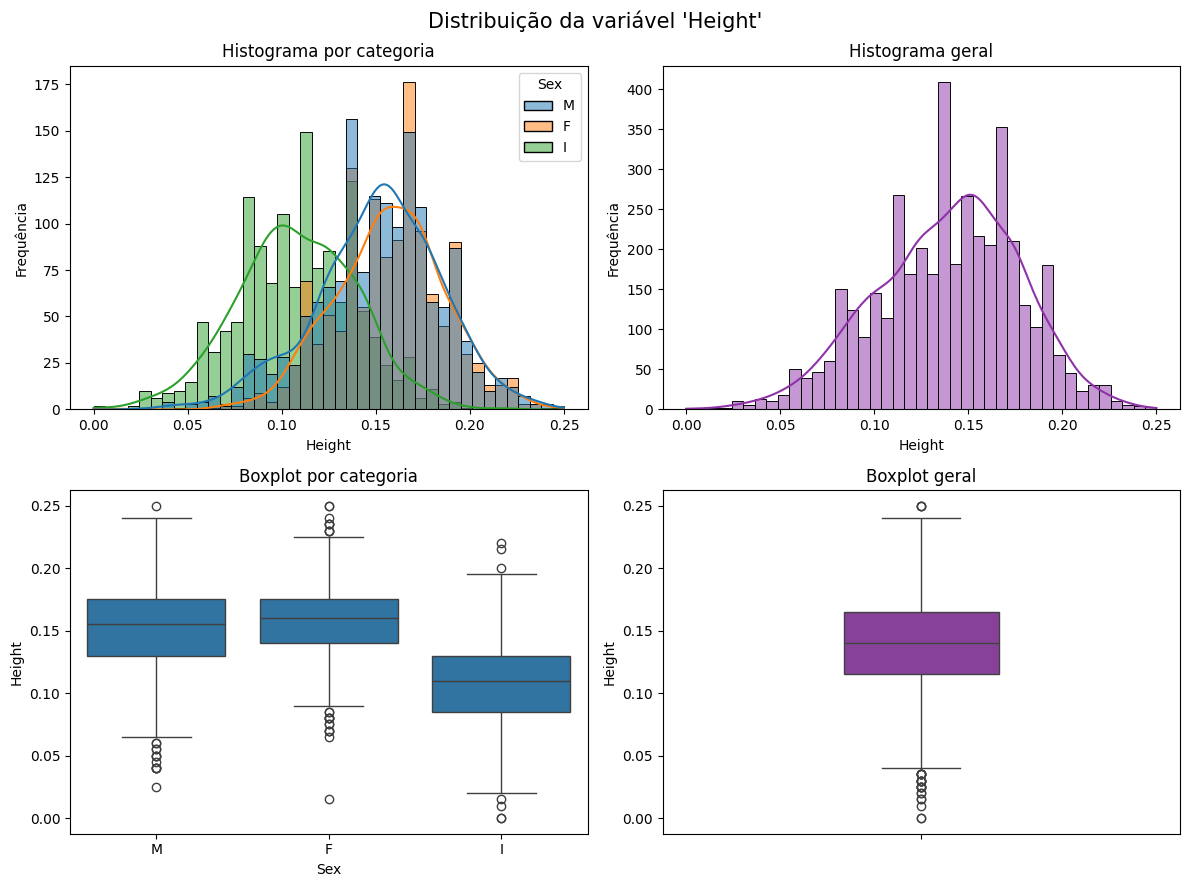

In [13]:
# Variáveis 'comprimento'
for col in data.columns[1:4]:
  plot_dist(dados=data, col=col, hue = 'Sex')

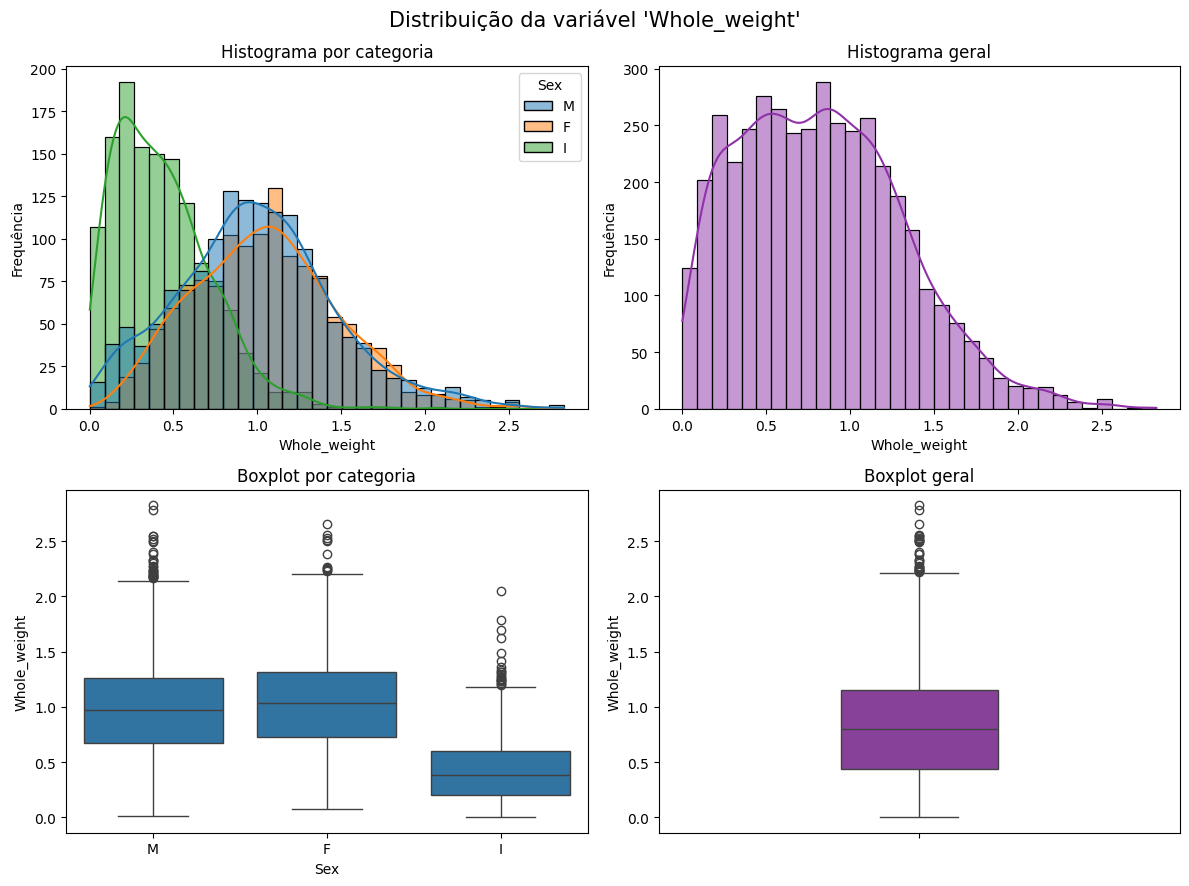

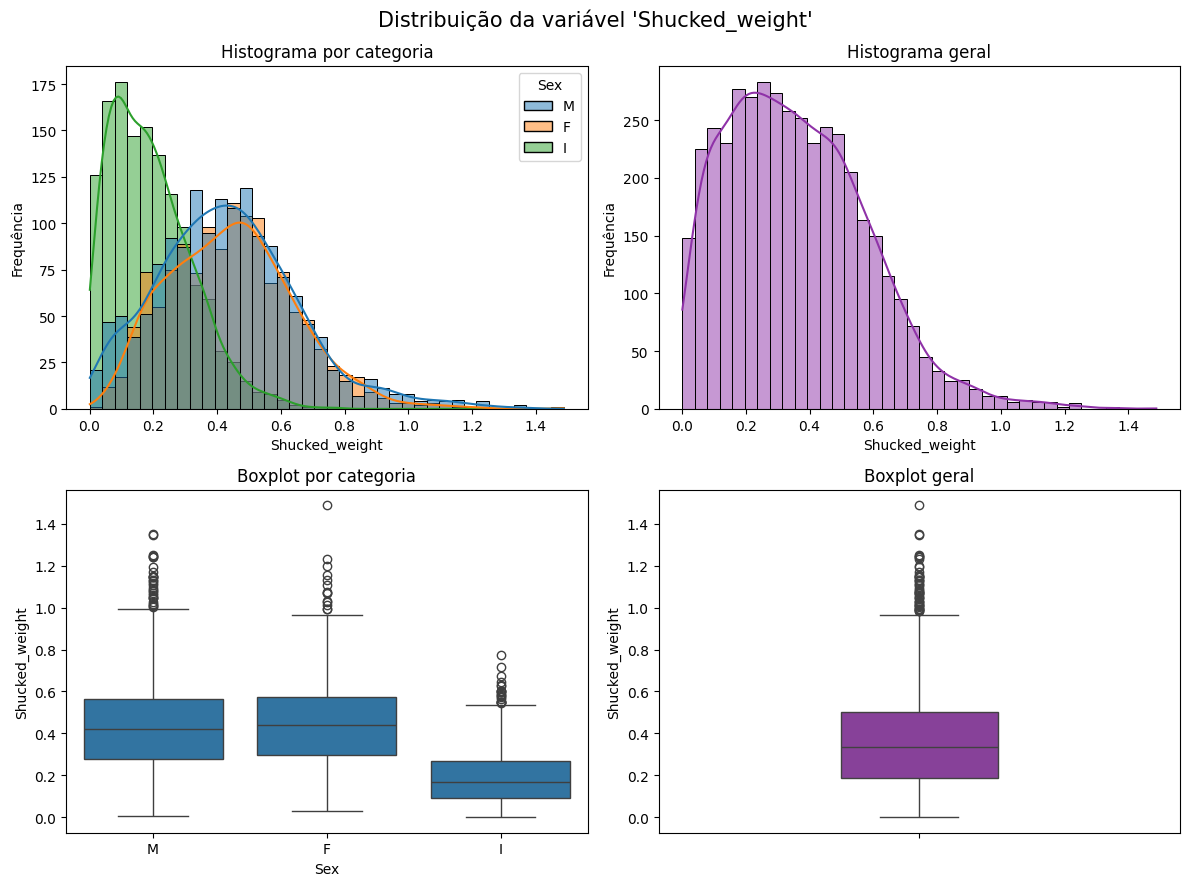

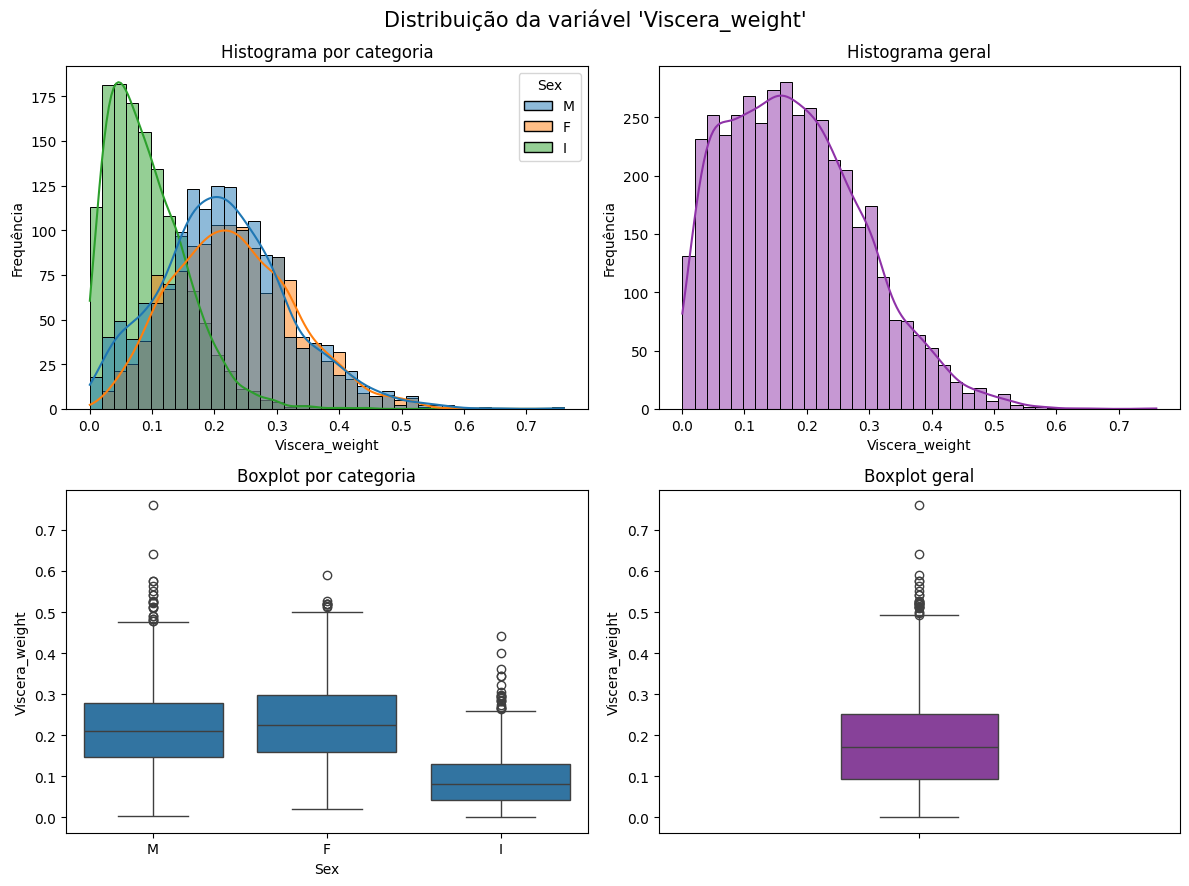

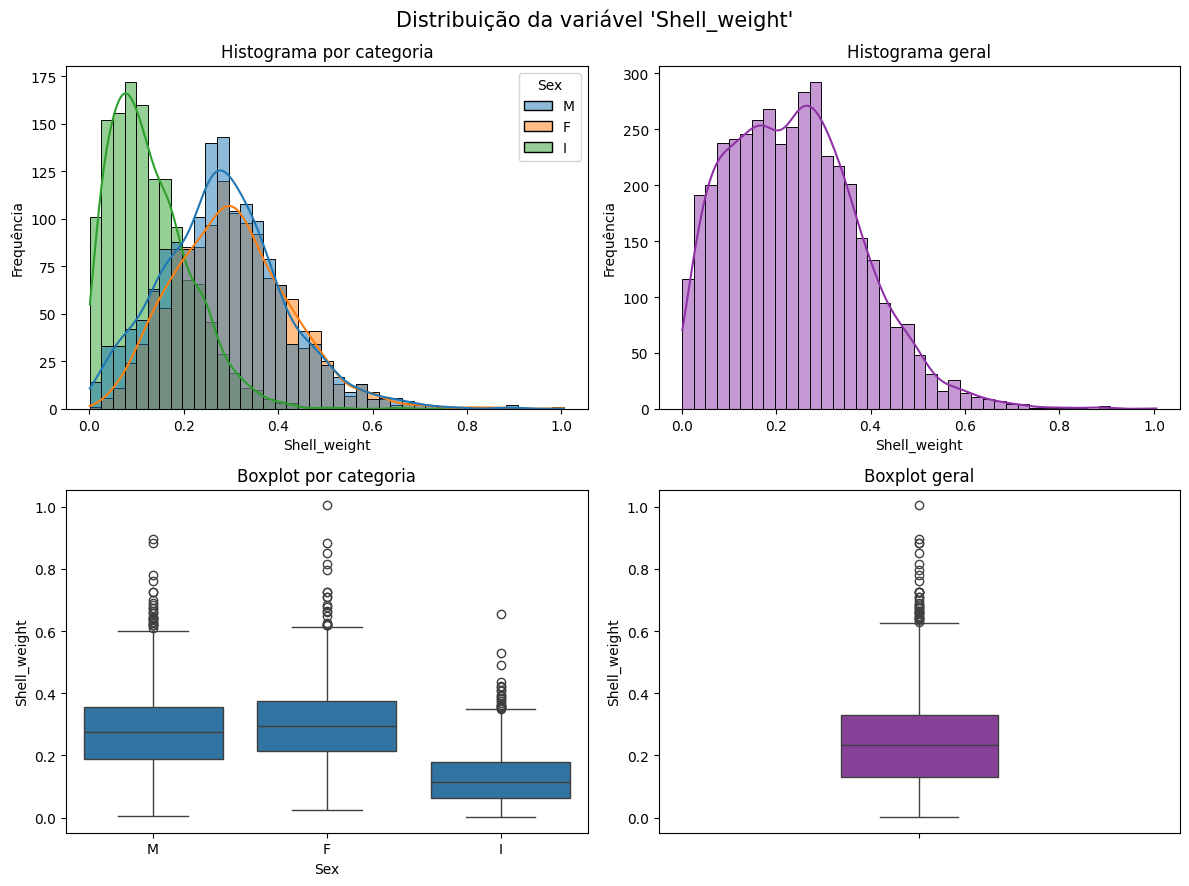

In [14]:
# Variáveis 'massa'
for col in data.columns[4:8]:
  plot_dist(dados=data, col=col, hue = 'Sex')

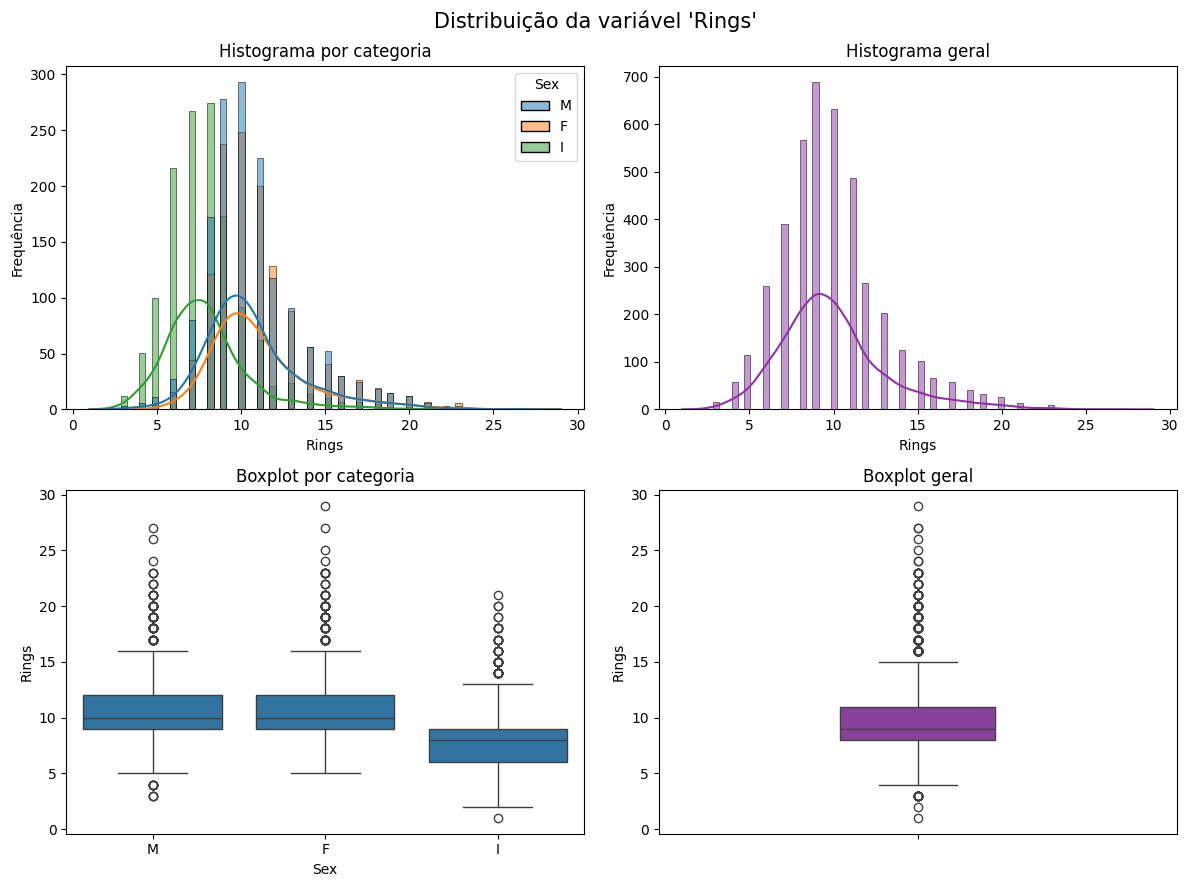

In [15]:
# Variável resposta
plot_dist(dados=data, col='Rings', hue = 'Sex')

A análise revela que a maioria das variáveis apresenta uma forma próxima à distribuição normal, embora exibam certo grau de assimetria. Esse comportamento sugere que a aplicação de transformações pode ser útil para aproximar essas distribuições da normalidade.

Quanto à variável Sex, percebe-se que indivíduos classificados como *M* e *F* tendem a apresentar valores semelhantes nas principais medidas. Já os pertencentes ao grupo *I* exibem valores consistentemente menores, tanto nas variáveis de massa quanto nas de comprimento, além da própria variável resposta. Esse padrão reflete naturalmente o fato de que organismos imaturos possuem dimensões reduzidas e menor peso em comparação aos adultos.


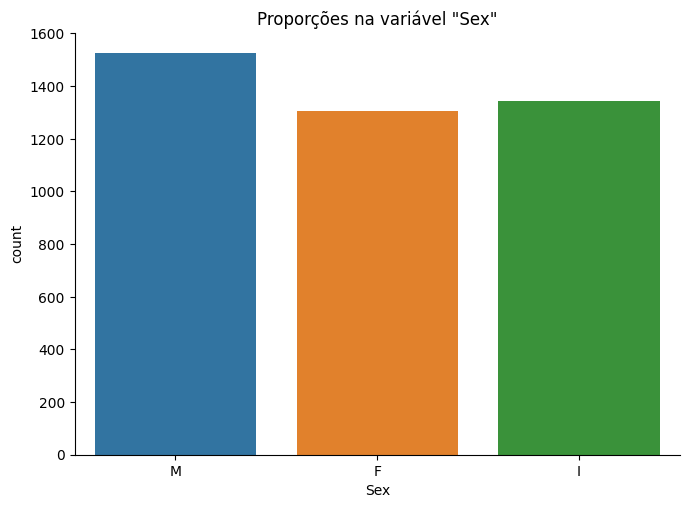

In [16]:
#Visualizado as proporções variável 'Sex'
plot_bar(dados = data, var = 'Sex', figsize = (7,5),
         title = 'Proporções na variável "Sex"')

A variável 'Sex' está aproximadamente balanceada.

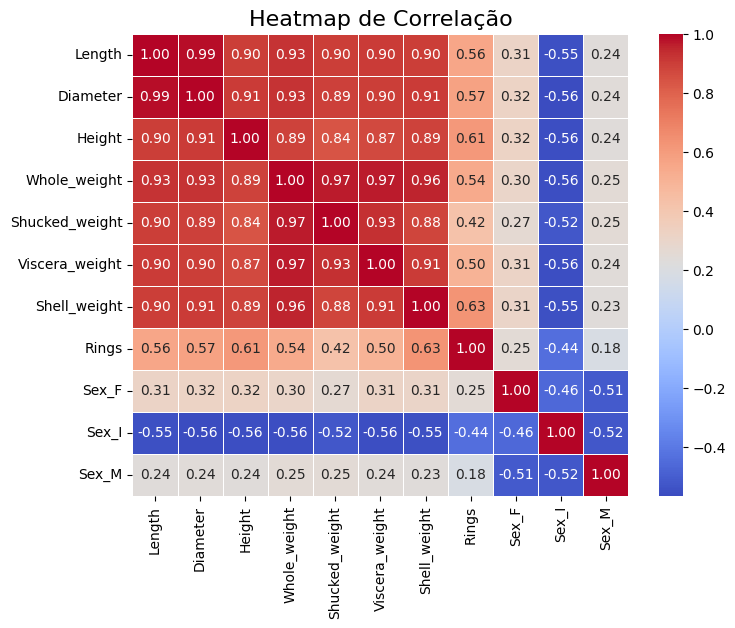

In [17]:
# Calculando a matriz de correlação
data_dummied = pd.get_dummies(data, columns=['Sex'])
corr = data_dummied.corr()

# Criando o heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Exibindo o gráfico
plt.title('Heatmap de Correlação', fontsize=16)
plt.show()

A visualização do heatmap reforça as conclusões já sugeridas pelos gráficos anteriores, revelando que:

* As variáveis relacionadas ao comprimento possuem correlação extremamente alta entre si.
* As variáveis de massa também exibem correlação elevada.
* Há ainda uma forte associação entre medidas de tamanho e de peso.

Esses padrões indicam que diversas variáveis carregam praticamente a mesma informação, o que abre espaço para reduzir a dimensionalidade nos modelos preditivos sem perda relevante de conteúdo.

Quanto à variável Sex, observa-se que as categorias *M* e *F* mantêm correlação muito baixa com as demais variáveis, enquanto a categoria *I* apresenta correlação negativa moderada. Isso sugere que essa variável tem contribuição limitada para explicar Rings, sendo possivelmente útil apenas para distinguir indivíduos imaturos, enquanto a diferenciação entre machos e fêmeas pouco acrescenta na predição da idade.


Principais conclusões:

* As medidas de comprimento apresentam correlação muito elevada entre si, o que permite escolher apenas uma delas como variável representativa no modelo, sem perda relevante de informação.
* O mesmo raciocínio vale para as variáveis associadas à massa, já que também carregam conteúdo altamente redundante.
* A variável Sex tende a ter impacto limitado na predição, pois suas categorias mostram correlação fraca com a variável alvo.
* A variável resposta apresenta baixa associação com os demais atributos, indicando que os modelos podem enfrentar dificuldades e resultar em erros de predição mais altos.
* Aplicar transformações nos dados pode ser uma estratégia útil para aproximar algumas distribuições da normalidade e melhorar o desempenho dos modelos.


# Comparando distribuições

O propósito desta etapa é investigar como diferentes transformações podem aproximar as variáveis de alguma distribuição conhecida, utilizando medidas descritivas e representações gráficas para orientar o processo.


## Definindo funções

O objetivo desta seção é avaliar possíveis transformações nos dados para verificar se eles podem ser aproximados de alguma distribuição conhecida, principalmente a distribuição normal. Isso é útil porque muitos métodos estatísticos e modelos preditivos assumem normalidade ou se beneficiam de dados mais simétricos e com variância estabilizada.

Para isso, utilizamos medidas descritivas (como média, mediana, desvio-padrão, assimetria e curtose) e visualizações gráficas (histogramas, Q-Q plots e boxplots). Esses recursos permitem:

* Identificar assimetria nas distribuições das variáveis, sugerindo quando uma transformação como log, raiz quadrada ou Box-Cox pode melhorar a simetria.
* Observar curtose elevada, que indica caudas pesadas e pode ser reduzida por transformações apropriadas.
* Detectar possíveis outliers, que podem influenciar a forma da distribuição ou indicar necessidade de transformações mais robustas.
* Avaliar se a variável resposta se aproxima de uma distribuição contínua comum ou se apresenta comportamento atípico que justifique ajustes.

Assim, a análise desta seção serve como uma etapa preparatória fundamental: ao transformar adequadamente as variáveis, buscamos melhorar o desempenho dos modelos, facilitar a interpretação dos resultados e verificar suposições estatísticas exigidas em análises posteriores.



In [18]:

# Calcula métricas descritivas básicas
def calcular_momentos(dados):
    media = np.mean(dados)
    variancia = np.var(dados)
    assimetria = stats.skew(dados)
    curtose = stats.kurtosis(dados)
    return media, variancia, assimetria, curtose

# Exibe de forma formatada os momentos calculados
def imprimir_momentos(media, variancia, assimetria, curtose):
    print(f"Média:      {media:7.4f}")
    print(f"Variância:  {variancia:7.4f}")
    print(f"Assimetria: {assimetria:7.4f}")
    print(f"Curtose:    {curtose:7.4f}")

# Parâmetros esperados caso os dados sigam uma normal
def estimar_normal(dados):
    mu = np.mean(dados)
    sigma2 = np.var(dados)
    return mu, sigma2, 0, 3  # assimetria e curtose teóricas da normal

# Parâmetros da distribuição de Poisson
def estimar_poisson(dados):
    lam = np.mean(dados)
    media = lam
    variancia = lam
    assimetria = 1 / np.sqrt(lam)
    curtose = 1 / lam
    return lam, media, variancia, assimetria, curtose

# Estimação para a distribuição binomial negativa
def estimar_binom_neg(dados):
    media = np.mean(dados)
    variancia = np.var(dados)
    p = media / variancia
    r = np.round(media**2 / (variancia - media))  # parâmetro inteiro
    media_teor = r * (1 - p) / p
    var_teor = r * (1 - p) / p**2
    assimetria = (2 - p) / np.sqrt(var_teor)
    curtose = (6 - 5 * p) / var_teor
    return r, p, media_teor, var_teor, assimetria, curtose

# Geração de QQ-plots com envelope de confiança
def qq_plot(dados, dist, params, nome_dist, ax):
    if params is None:
        params = ()

    # Quantis observados e teóricos
    n = len(dados)
    probs = (np.arange(1, n + 1) - 0.5) / n
    quant_teor = dist.ppf(probs, *params)
    quant_emp = np.sort(dados)

    # Densidade utilizada no intervalo de confiança
    if hasattr(dist, "pdf"):
        dens = dist.pdf(quant_teor, *params)
    else:
        dens = dist.pmf(np.round(quant_teor), *params)

    # Construção do envelope de 95%
    erro = np.sqrt(probs * (1 - probs) / (n * dens**2))
    z = stats.norm.ppf(0.975)
    lim_sup = quant_teor + z * erro
    lim_inf = quant_teor - z * erro

    # Plot
    ax.scatter(quant_teor, quant_emp, label="Quantis Empíricos")
    ax.plot(quant_teor, quant_teor, "r--", label="Linha Ideal")
    ax.fill_between(quant_teor, lim_inf, lim_sup, color="blue", alpha=0.2, label="95% IC")

    ax.set_title(f"QQ-Plot: {nome_dist}")
    ax.set_xlabel("Quantis Teóricos")
    ax.set_ylabel("Quantis Empíricos")
    ax.legend()
    ax.grid(True)


## Explorando as distribuições

Vamos comparar a média, variância, assimetria e curtose da variável resposta com as mesmas medidas obtidas em diferentes distribuições, a fim de avaliar qual delas melhor se ajusta aos dados.

As distribuições consideradas serão:

* Normal
* Poisson
* Binomial Negativa

As duas últimas foram incluídas por serem distribuições discretas comumente aplicadas a dados de contagem.


In [21]:
rings = data['Rings']

# Medidas descritivas dos dados observados
media_obs, var_obs, assimetria_obs, curtose_obs = calcular_momentos(rings)

print("Medidas dos dados observados:")
print_momentos(media_obs, var_obs, assimetria_obs, curtose_obs)

# Distribuição Normal
mu, sigma2, assimetria_norm, curtose_norm = estima_norm(rings)
print(f"\nDistribuição Normal (μ = {mu:.4f}, σ² = {sigma2:.4f}):")
print_momentos(mu, sigma2, assimetria_norm, curtose_norm)

# Distribuição Poisson
l, media_pois, variancia_pois, assimetria_pois, curtose_pois = estima_pois(rings)
print(f"\nDistribuição Poisson (λ = {l:.4f}):")
print_momentos(media_pois, variancia_pois, assimetria_pois, curtose_pois)

# Distribuição Binomial Negativa
r, p, media_bneg, variancia_bneg, assimetria_bneg, curtose_bneg = estima_bneg(rings)
print(f"\nDistribuição Binomial Negativa (r = {r:.0f}, p = {p:.4f}):")
print_momentos(media_bneg, variancia_bneg, assimetria_bneg, curtose_bneg)


Medidas dos dados observados:
Média:       9.9341
Variância:  10.3969
Assimetria:  1.1132
Curtose:     2.3242

Distribuição Normal (μ = 9.9341, σ² = 10.3969):
Média:       9.9341
Variância:  10.3969
Assimetria:  0.0000
Curtose:     3.0000

Distribuição Poisson (λ = 9.9341):
Média:       9.9341
Variância:   9.9341
Assimetria:  0.3173
Curtose:     0.1007

Distribuição Binomial Negativa (r = 213, p = 0.9555):
Média:       9.9214
Variância:  10.3836
Assimetria:  0.3241
Curtose:     0.1177


A respeito dos gráficos quantil-quantil:

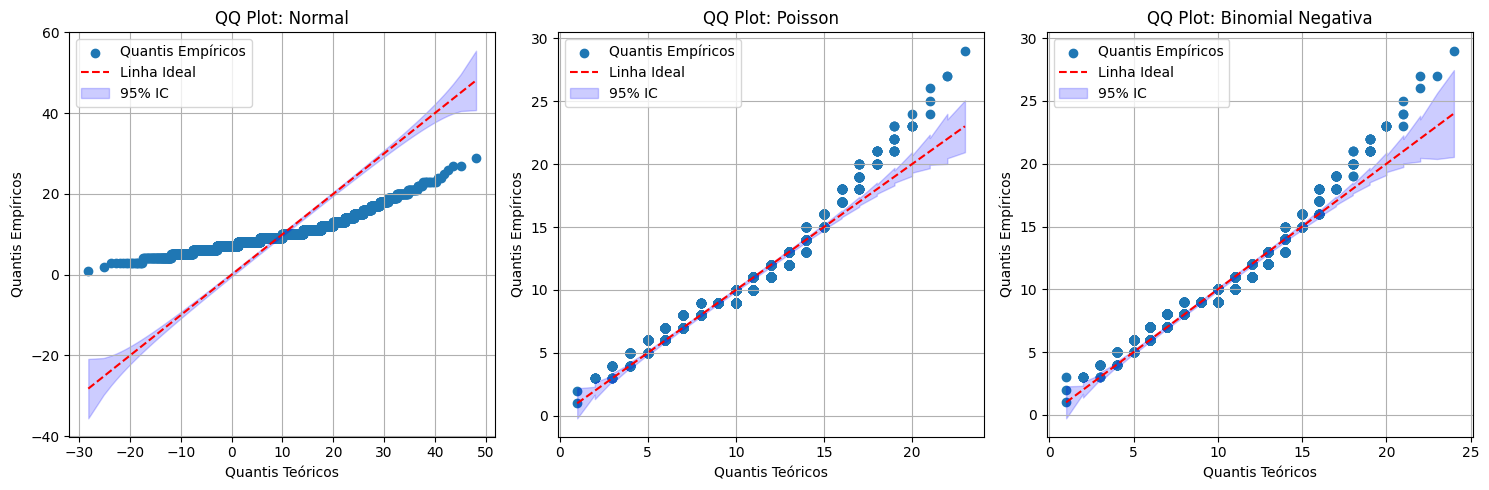

In [22]:
# Desenhando gráficos QQ
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Normal
qq_plot(rings, stats.norm, (mu, sigma2), "Normal", ax=axes[0])

# Poisson
qq_plot(rings, stats.poisson, (l,), "Poisson", ax=axes[1])

# Binomial Negativa
qq_plot(rings, stats.nbinom, (r, p), "Binomial Negativa", ax=axes[2])

plt.tight_layout()
plt.show()


A análise dos QQ-plots reforça que nenhuma das distribuições avaliadas descreve adequadamente o comportamento da variável Rings.

Para a distribuição Normal, observa-se um desvio substancial em ambas as extremidades, indicando forte assimetria positiva e caudas incompatíveis com a normalidade teórica — comportamento esperado para dados de contagem.

O ajuste sob a Poisson também se mostra insatisfatório: embora os quantis centrais se alinhem moderadamente à reta ideal, as caudas apresentam desvios sistemáticos, evidenciando superdispersão (variância substancialmente maior que a média), condição que viola a suposição fundamental desse modelo.

A Binomial Negativa, por sua vez, oferece um alinhamento superior em relação à Poisson, especialmente na região intermediária da distribuição; ainda assim, persistem discrepâncias relevantes nas caudas superiores, sugerindo que, apesar de capturar melhor a dispersão, o modelo continua insuficiente para representar toda a estrutura dos dados.

Assim, os gráficos indicam que a variável Rings não segue de forma satisfatória nenhuma das distribuições paramétricas consideradas.


# Conclusão da Seção

Durante a etapa de análise exploratória, foram examinadas tanto as distribuições das variáveis quanto suas interdependências, por meio de visualizações gráficas e estatísticas descritivas. Observou-se que os atributos físicos, como comprimento, diâmetro e medidas de massa, apresentam correlações moderadas a fortes, indicando que parte das informações é redundante e que variáveis morfométricas simples podem servir como boas representantes do conjunto.

Por outro lado, a variável Rings, utilizada como proxy de idade, demonstrou apenas uma associação fraca com os demais atributos, o que limita a eficácia de modelos que assumam relação linear direta. Além disso, constatou-se que a variável Sex pouco contribui para diferenciar indivíduos adultos, embora o grupo classificado como "infant" apresente padrões morfológicos nitidamente distintos das demais categorias.
